Projet 5 : Catégorisez automatiquement des questions sur Stack Overflow

Vectorisation

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# Import Python libraries
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import re
import spacy
import gensim
import multiprocessing
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn import manifold, decomposition
import sklearn.metrics as metrics

In [19]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.6 MB/s eta 0:00:00


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer


from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import os
import transformers
from transformers import AutoTokenizer, AutoConfig, TFAutoModel
#import tensorflow_hub as hub
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
os.environ["TF_KERAS"]='1'
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [22]:
#Import des données
global data
from google.colab import drive
drive.mount('/content/gdrive')
#Import des données
data= pd.read_csv('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/data_cleaned400.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
data = data.drop(columns=['Title','Body','Tags','Id','document','document_cleaned','Body_cleaned', 'Title_cleaned'])

In [24]:
data = data.astype(str)

In [25]:
data.head()

,frequent_tags,frequent_word
0,java multithreading,java arraylist string thread answer data struc...
1,php html,post practice web application php mysql show l...
2,ios objective-c xcode,error view controller error view controller in...
3,javascript html css,google map custom default google map map custom
4,mysql sql,table query table name phone data input table ...


In [26]:
data[data['frequent_word'].str.contains(' c ')]

,frequent_tags,frequent_word
33,python list,function zip list item convert list item list ...
49,c# .net winforms,path display label method path string example ...
86,sql sql-server database performance,join query c c join perform case result
99,c++ c,use c c++ operator device bit controller integ...
132,c++ c,c c++ standard document question answer standa...
...,...,...
45498,html css,svg drop css drop svg element css box webkit b...
45517,java,library project work java project call custom ...
45520,java,tomcat write web application eclipse tomcat wo...
45522,c,mean follow error try compile c application bi...


Transformation des tags en liste de mot

In [27]:
tags = data['frequent_tags'].apply(lambda x: x.split())
tags

0           [java, multithreading]
1                      [php, html]
2        [ios, objective-c, xcode]
3          [javascript, html, css]
4                     [mysql, sql]
                   ...            
45541              [php, security]
45542               [c#, winforms]
45543                       [java]
45544                 [javascript]
45545                  [algorithm]
Name: frequent_tags, Length: 45546, dtype: object

Le MultiLabelBinarizer est une classe qui est souvent utilisée dans le traitement de données en apprentissage automatique, en particulier dans les tâches de classification multi-étiquettes. Cette classe permet de transformer les étiquettes textuelles (ou catégoriques) en vecteurs binaires pour faciliter l'entraînement des modèles de classification.

Pour entraîner un modèle de classification, nous avons besoin de transformer ces étiquettes en vecteurs binaires. Le MultiLabelBinarizer permet de faire cette transformation de manière simple et efficace.

In [28]:
from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(tags)

# transform target variable
y = multilabel_binarizer.transform(tags)

In [30]:
joblib.dump(multilabel_binarizer, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/multilabel.joblib', 'wb'), compress=True)

Chaque ligne du vecteur représente une image, et chaque colonne représente une étiquette (dans l'ordre alphabétique). Si une étiquette est présente pour une image, la valeur correspondante dans le vecteur est 1, sinon elle est 0.

In [19]:
a=data['frequent_tags'].tolist()
a = ' '.join(a)
print('Nombre de tags :', len(set(a.split())))

Nombre de tags : 61


In [ ]:
#Sauvegarde
joblib.dump(multilabel_binarizer, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/multilabel.joblib', 'wb'), compress=True)  #Model
joblib.dump(tags, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/tags.joblib', 'wb'), compress=True) #Features

In [91]:
# Define X and y
X = data["frequent_word"]
X=list(X)

In [ ]:
#Sauvegarde
joblib.dump(X, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X.joblib', 'wb'))

le TD-IDF est une méthode pour mesurer l'importance d'un mot dans un document en comparant sa fréquence dans le document à sa fréquence dans l'ensemble des documents. Les mots qui ont un score élevé sont considérés comme importants pour le document.

- La première partie, "Term Frequency", mesure la fréquence d'apparition d'un mot dans un document.
  Par exemple, si le mot "France" apparaît 10 fois dans un document de 1000 mots, la fréquence du terme sera de $ \frac{n}{N} =\frac{10}{1000} = 0,01$.

- La seconde partie, "Inverse Document Frequency", mesure l'importance d'un mot dans le corpus.
  Cette mesure est calculée en utilisant la formule $log(\frac{N}{n})$, où N est le nombre total de documents et n est le nombre de documents dans lesquels le mot apparaît.

  En multipliant ces deux mesures, on obtient un score TD-IDF pour chaque mot dans chaque document. Les mots qui ont un score élevé sont considérés comme importants pour le document.      


  Par exemple, si dans mon dataset un document contient le mot "C#" 10 fois et que le mot n'apparaît que dans 100 des 50 000 documents de la base de données, alors le score TD-IDF pour le mot "C#" dans ce document sera de $ 0,01 \times log(\frac{50 000}{100}) = 0,027$.

## 1) <ins> Vectorisation TFIDF

https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25, random_state=8)

In [ ]:
X[:1]

['java arraylist string thread answer data structure object string value data structure change thread change list change reference change wonder data structure thread object information structure thread']

In [ ]:
joblib.dump(X_train, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_train.joblib', 'wb'), compress=True)
joblib.dump(X_test, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_test.joblib', 'wb'), compress=True)

joblib.dump(y_train, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_train.joblib', 'wb'), compress=True)
joblib.dump(y_test, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_test.joblib', 'wb'), compress=True)

In [ ]:
#Nous fixons également la valeur de min_df à 10, ce qui signifie que seuls les mots apparaissant dans au moins 10 documents seront inclus dans les fonctionnalités
#tfidf_vectorizer =  TfidfVectorizer(analyzer="word", max_df=.6, min_df=0.005) # check  le fréquence max des mots afin de choisir la valeur du paramètre min_df
tfidf_vectorizer =  TfidfVectorizer(analyzer="word", min_df=10) # check  le fréquence max des mots afin de choisir la valeur du paramètre min_df

# create TF-IDF features
X_tfidf_train = tfidf_vectorizer.fit_transform(X_train)
X_tfidf_test = tfidf_vectorizer.transform(X_test)
#X_test_tfidf = tfidf_vectorizer.transform(X_test)
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()

In [ ]:
#Sauvegarde
joblib.dump(tfidf_vectorizer, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/tfidf_vectorizer.joblib', 'wb'), compress=True)  # Model
joblib.dump(X, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_tfidf.joblib', 'wb')) #Features

In [ ]:
print("Le jeu d'entrainement comporte {} documents pour {} mots".format(X_tfidf_train.shape[0], X_tfidf_train.shape[1]))
print("Le jeu de Test comporte {} documents pour {} mots".format(X_tfidf_test.shape[0], X_tfidf_test.shape[1]))

Le jeu d'entrainement comporte 34159 documents pour 1008 mots
Le jeu de Test comporte 11387 documents pour 1008 mots


In [ ]:
# Transformation en matrice dense pour visualiser
X_tfidf_train = pd.DataFrame(X_tfidf_train.todense(), columns=feature_names_tfidf)
X_tfidf_test = pd.DataFrame(X_tfidf_test.todense(), columns=feature_names_tfidf)

In [ ]:
X_tfidf_train.head() #vbash

,abc,access,accord,account,action,activerecord,activity,activitythread,adapter,address,...,write,writeline,www,xcode,xml,xmlns,xxx,year,zip,zygoteinit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
joblib.dump(X_tfidf_train, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_tfidf_train.joblib', 'wb'), compress=True)
joblib.dump(X_tfidf_test, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_tfidf_test.joblib', 'wb'), compress=True)

## <ins> Vectorisation Word2Vec

 la fonction simple_preprocess de la bibliothèque Gensim pour prétraiter les données d'entraînement.
  La fonction simple_preprocess prend une chaîne de caractères en entrée et retourne une liste de tokens (mots) prétraités.

In [ ]:
w2v_size=200
w2v_window=8
w2v_min_count=1
w2v_epochs=100
maxlen = 30 # adapt to length of sentences

sentences_train = [gensim.utils.simple_preprocess(text) for text in X_train] # --> Tokénization
sentences_test = [gensim.utils.simple_preprocess(text) for text in X_test]

La fonction Word2Vec crée une nouvelle instance de modèle Word2Vec avec des hyperparamètres spécifiés tels que :
- min_count (nombre minimum d'occurrences d'un mot pour être inclus dans le vocabulaire),

- window (taille de la fenêtre de contexte pour laquelle les co-occurrences de mots sont comptées),

  - Cela signifie que pour chaque mot dans chaque phrase d'entraînement, le modèle considérera les deux mots

  - précédents et les deux mots suivants comme faisant partie de son contexte.
  
  - Par exemple, pour la phrase 'le chat est sur le tapis', le modèle considérera que 'chat' est en relation avec 'le', 'est', 'sur', et 'le'.

- vector_size (nombre de dimensions pour représenter les vecteurs de mots),
- seed (numéro de graine aléatoire pour la reproductibilité des résultats) et workers (nombre de threads pour l'entraînement parallèle).
- workers (nombre de threads pour l'entraînement parallèle).

La méthode build_vocab construit le vocabulaire du modèle à partir de sentences_train, qui contient une liste de tokens prétraités pour chaque document.

In [ ]:
%%time
#Maintenant, nous pouvons entraîner le modèle Word2Vec en utilisant ces phrases
#Chaque mot du vocabulaire est associé à un vecteur de taille w2v_size
# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count,
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=multiprocessing.cpu_count() - 1)
w2v_model.build_vocab(sentences_train) # -->construis le vocabulaire du corpus
w2v_model.train(sentences_train, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words)) # vocabulaire du corpus
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 1005
Word2Vec trained
CPU times: user 4min 45s, sys: 1.3 s, total: 4min 46s
Wall time: 4min 58s


Il n'y a pas de valeur "idéale" pour le paramètre vector_size, car cela dépendra de la taille et de la complexité du corpus d'entraînement, ainsi que de la nature spécifique du problème de traitement du langage naturel à résoudre.

En général, un vector_size plus grand peut aider à capturer des informations sémantiques plus riches sur les mots, tandis qu'un vector_size plus petit peut être plus efficace pour les tâches de classification de texte ou de recherche d'informations.

Cependant, il est important de noter que des valeurs de vector_size très élevées peuvent également entraîner des temps d'entraînement plus longs et une consommation de mémoire plus importante. Il est courant de voir des valeurs de vector_size dans la plage de 50 à 300 dans la pratique, mais cela dépendra du corpus d'entraînement et des besoins spécifiques de l'application.

Pendant l'entraînement, le modèle Word2Vec apprend à représenter chaque mot du vocabulaire sous forme d'un vecteur dense dans un espace vectoriel de grande dimension. L'objectif est d'apprendre des représentations vectorielles qui capturent les relations sémantiques et syntaxiques entre les mots dans le corpus, de sorte que les mots similaires soient représentés par des vecteurs similaires et que les mots différents soient représentés par des vecteurs différents. Les vecteurs appris peuvent ensuite être utilisés pour diverses tâches de traitement automatique du langage naturel (TALN), telles que la classification de texte, la recherche d'informations et la génération de langage.

Pendant l'entraînement, le modèle Word2Vec apprend à représenter chaque mot du vocabulaire sous forme d'un vecteur dense dans un espace vectoriel de grande dimension. L'objectif est d'apprendre des représentations vectorielles qui capturent les relations sémantiques et syntaxiques entre les mots dans le corpus, de sorte que les mots similaires soient représentés par des vecteurs similaires et que les mots différents soient représentés par des vecteurs différents. Les vecteurs appris peuvent ensuite être utilisés pour diverses tâches de traitement automatique du langage naturel (TALN), telles que la classification de texte, la recherche d'informations et la génération de langage.

In [ ]:
%%time
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
# Train set
train_token = Tokenizer()
train_token.fit_on_texts(sentences_train)
train_sentences = pad_sequences(train_token.texts_to_sequences(sentences_train),
                                maxlen=maxlen,
                                padding='post') #Chaque est associé à un index
word_index_train = train_token.word_index
# Test set
test_token = Tokenizer()
test_token.fit_on_texts(sentences_test)
test_sentences = pad_sequences(test_token.texts_to_sequences(sentences_test),
                               maxlen=maxlen,
                               padding='post')
word_index_test = test_token.word_index
print("Number of unique words: %i in training set" % len(word_index_train))
print("Number of unique words: %i in testing set" % len(word_index_test))

Fit Tokenizer ...
Number of unique words: 1005 in training set
Number of unique words: 1005 in testing set
CPU times: user 1.69 s, sys: 18 ms, total: 1.71 s
Wall time: 1.7 s


## Création de la matrice d'embedding

Chaque ligne de la matrice correspond à un mot spécifique du vocabulaire.Chaque ligne de la matrice correspond à un mot spécifique du vocabulaire. Par exemple, la première ligne peut représenter le mot "le", la deuxième ligne peut représenter le mot "chat", la troisième ligne peut représenter le mot "mange", etc. Les valeurs numériques dans chaque ligne sont les composantes du vecteur d'embedding pour ce mot dans l'espace vectoriel.

La matrice d'embedding est utilisée pour initialiser les embeddings dans un modèle d'apprentissage automatique ou de traitement du langage naturel. Les vecteurs d'embedding captent les informations sémantiques des mots, ce qui permet au modèle de comprendre les relations et les similarités entre les mots lors de l'apprentissage et de la prédiction.

In [ ]:
%%time
# Création de la matrice d'embedding
#Les mots sont en lignes --> vecteurs de mots horizontaux
print("Create Embedding matrix ...")
w2v_size = 200
vocab_size_train = len(word_index_train) + 1
vocab_size_test = len(word_index_test) + 1
embedding_matrix_train = np.zeros((vocab_size_train, w2v_size))
embedding_matrix_test = np.zeros((vocab_size_test, w2v_size))
i=0
j=0

for word, idx in word_index_train.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix_train[idx] = model_vectors[word]
i, j = 0, 0
for word, idx in word_index_test.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix_test[idx] = model_vectors[word]

word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix for Train : %s" % str(embedding_matrix_train.shape))
print("Embedding matrix for Test : %s" % str(embedding_matrix_test.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix for Train : (1006, 200)
Embedding matrix for Test : (1006, 200)
CPU times: user 19.7 ms, sys: 0 ns, total: 19.7 ms
Wall time: 19.3 ms


In [ ]:
embedding_matrix_train

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.41498411, -0.18387386,  1.21946788, ...,  0.39235005,
        -0.782309  , -0.59534991],
       [ 0.91709828, -1.63721454,  0.18678904, ..., -1.21332073,
         0.67723513, -1.66912067],
       ...,
       [-0.17743368,  0.7517184 ,  2.57121062, ...,  1.97685707,
         0.88347971, -0.24820642],
       [-0.69480842,  0.36158264,  0.01600075, ...,  0.48977375,
         0.17347184, -2.32950354],
       [-1.21359444,  0.00635134, -2.11245418, ...,  0.42029679,
        -0.30319941,  2.32590175]])

## Création du modèle d'embedding

Nous définissons ensuite la longueur maximale de nos phrases maxlen.

Nous créons ensuite deux objets Input avec les formes appropriées pour représenter les phrases et les mots individuels. Nous utilisons la couche Embedding de Keras pour créer la couche d'embedding, en utilisant la matrice d'embedding aléatoire que nous avons créée précédemment. Enfin, nous utilisons la couche GlobalAveragePooling1D pour calculer la moyenne de chaque vecteur d'embedding dans chaque phrase.

Enfin, nous créons le modèle en utilisant la fonction Model de Keras, en utilisant les objets Input pour définir l'entrée et la sortie du modèle. Le modèle prendra en entrée des phrases représentées par des vecteurs de longueur maxlen, et renverra des vecteurs d'embedding uniques pour chaque phrase.

https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce

En résumé, ce code définit un modèle qui prend en entrée des séquences d'entiers représentant des phrases, utilise une couche d'embedding pour obtenir des vecteurs d'embedding pour chaque mot, agrège ces embeddings en utilisant la moyenne, et génère des représentations vectorielles des phrases. Ce modèle peut être utilisé pour l'apprentissage automatique sur des données textuelles, telles que la classification ou la préd

In [ ]:
%%time
# Création du modèle train

input=Input(shape=(len(train_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size_train,
                         output_dim=w2v_size,
                         weights = [embedding_matrix_train],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model_train = Model([word_input],word_vec)

embed_model_train.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 200)           201200    
                                                                 
 global_average_pooling1d (G  (None, 200)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 201,200
Trainable params: 201,200
Non-trainable params: 0
_________________________________________________________________
CPU times: user 757 ms, sys: 555 ms, total: 1.31 s
Wall time: 3.07 s


In [ ]:
# Création du modèle test

input = Input(shape=(len(test_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')
word_embedding=Embedding(input_dim=vocab_size_test,
                         output_dim=w2v_size,
                         weights = [embedding_matrix_test],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)
embed_model_test = Model([word_input],word_vec)

embed_model_test.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 30, 200)           201200    
                                                                 
 global_average_pooling1d_1   (None, 200)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 201,200
Trainable params: 201,200
Non-trainable params: 0
_________________________________________________________________


#### Exécution du modèle

In [ ]:
X_w2v_train = embed_model_train.predict(train_sentences)
X_w2v_train.shape

1068/1068 [==============================] - 1s 1ms/step


(34159, 200)

In [ ]:
X_w2v_test = embed_model_test.predict(test_sentences)
X_w2v_test.shape

356/356 [==============================] - 0s 1ms/step


(11387, 200)

In [ ]:
X_w2v_train

array([[-0.03510324, -0.2961052 ,  0.00162528, ..., -0.4699903 ,
         0.38590568,  0.042771  ],
       [-0.63020885, -0.06661846,  0.17279579, ..., -0.2935537 ,
        -0.40356514, -0.5864563 ],
       [-0.35347253,  0.8949185 , -0.22405161, ...,  0.2869673 ,
         0.13545065, -0.49181348],
       ...,
       [-0.3878775 , -0.1554371 , -0.35222566, ...,  0.49198645,
        -0.12448049, -0.3108837 ],
       [-0.00204232,  0.99778396, -0.7863161 , ...,  0.597701  ,
         0.7560778 ,  0.30869064],
       [-0.04434367,  0.00373292,  0.0841335 , ...,  0.17396107,
        -0.12012369,  0.00464218]], dtype=float32)

In [ ]:
#Sauvegarde
joblib.dump(w2v_model, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/embed_model_train.joblib', 'wb'), compress=True)
joblib.dump(X_w2v_train, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_w2v_train.joblib', 'wb'))
joblib.dump(X_w2v_test, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_w2v_test.joblib', 'wb'))

LDA à faire que pour le TDF-IDF

## 2) <ins> Vectorisation de BERT

In [16]:
import os
import transformers
from transformers import AutoTokenizer, AutoConfig, TFAutoModel
import tensorflow_hub as hub
import tensorflow as tf
import time

In [17]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True,
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")

        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0],
                             bert_inp['token_type_ids'][0],
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)

    return input_ids, token_type_ids, attention_mask, bert_inp_tot


# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size],
                                                                      bert_tokenizer, max_length)

        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids,
                                 "input_mask" : attention_mask,
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']

        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))

    features_bert = np.array(last_hidden_states_tot).mean(axis=1)

    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)

    return features_bert, last_hidden_states_tot

#### 'bert-base-uncased'

In [ ]:
X_train = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_train.joblib')
X_test = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_test.joblib')

In [14]:
%%time
max_length = 16
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
#sentences_train = X_train
#sentences_test = X_test


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

CPU times: user 5.01 s, sys: 1.01 s, total: 6.01 s
Wall time: 5.45 s


In [21]:
%%time
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, X,
                                                       max_length, batch_size, mode='HF')

1/1 [==============================] - 0s 411ms/step
temps traitement :  3672.0
CPU times: user 1h 38s, sys: 9min 6s, total: 1h 9min 45s
Wall time: 1h 1min 12s


In [64]:
#joblib.dump(features_bert, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/features_bert.joblib', 'wb'))
features_bert=joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/features_bert.joblib')

In [65]:
# Import the necessary module
from sklearn import preprocessing

In [66]:
data_features_bert=pd.DataFrame(features_bert)

In [67]:
data_bert = pd.concat((data_features_bert, tags[:45546]),axis=1)

In [68]:
data_feat_bert = data_bert.drop(columns = ['frequent_tags'])
scaler = preprocessing.StandardScaler()
label_encoder = preprocessing.LabelEncoder()

data_transformed_bert = scaler.fit_transform(data_feat_bert)

In [69]:
# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(data_bert['frequent_tags'])
y_binarized_bert = multilabel_binarizer.transform(data_bert['frequent_tags'])

In [70]:
# Create train and test split (20%)
X_train_bert,  X_test_bert,  y_train_bert, y_test_bert = train_test_split(data_transformed_bert, y_binarized_bert,
                                                    test_size=0.25, random_state=8)
print("X_train shape : {}".format(X_train_bert.shape))
print("X_test shape : {}".format(X_test_bert.shape))
print("y_train shape : {}".format(y_train_bert.shape))
print("y_test shape : {}".format(y_test_bert.shape))

X_train shape : (34159, 768)
X_test shape : (11387, 768)
y_train shape : (34159, 61)
y_test shape : (11387, 61)


In [71]:
X_train_bert[~np.isfinite(X_train_bert)] = 0
X_test_bert[~np.isfinite( X_test_bert)] = 0
y_train_bert[~np.isfinite(y_train_bert)] = 0
y_test_bert[~np.isfinite(y_test_bert)] = 0

-- Temps long --> Entrainer sur une partie des données (25 ou 50%)

In [72]:
#Sauvegarde
joblib.dump(X_train_bert, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_train_bert.joblib', 'wb'))
joblib.dump(X_test_bert, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_test_bert.joblib', 'wb'))
joblib.dump(y_train_bert, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_train_bert.joblib', 'wb'))
joblib.dump(y_test_bert, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_test_bert.joblib', 'wb'))

# 3) <ins> Vectorisation de USE (Universal Sentence Encoder)

In [88]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [89]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [92]:
%%time
batch_size = 10
#X_use_train= feature_USE_fct(X_train, batch_size)
#X_use_test = feature_USE_fct(X_test, batch_size)
X_use= feature_USE_fct(X, batch_size)
X_use.shape

CPU times: user 1min 29s, sys: 37.6 s, total: 2min 7s
Wall time: 1min 59s


(45540, 512)

In [93]:
from sklearn import preprocessing
X_use_df=pd.DataFrame(X_use)
X_use_df_tags = pd.concat((X_use_df, tags),axis=1)
#X_use_df_tags.dropna(inplace=True)
X_use_df_tags.shape

(45546, 513)

In [94]:
data_feat_use = X_use_df_tags.drop(columns = ['frequent_tags'])
scaler = preprocessing.StandardScaler()
label_encoder = preprocessing.LabelEncoder()
data_transformed_use = scaler.fit_transform(data_feat_use)

In [95]:
# Multilabel binarizer for targets
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(X_use_df_tags['frequent_tags'])
y_binarized_use = multilabel_binarizer.transform(X_use_df_tags['frequent_tags'])

In [96]:
X_use_train, X_use_test, y_use_train, y_use_test = train_test_split(data_transformed_use,y_binarized_use,
                                                    test_size=0.25, random_state=8)

In [98]:
X_use_train[~np.isfinite(X_use_train)] = 0
y_use_train[~np.isfinite(y_use_train)] = 0
y_use_test[~np.isfinite(y_use_test)] = 0
X_use_test[~np.isfinite(X_use_test)] = 0

In [99]:
#Sauvegarde
joblib.dump(X_use_train, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_use_train.joblib', 'wb'))
joblib.dump(X_use_test, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_use_test.joblib', 'wb'))
joblib.dump(y_use_train, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_use_train.joblib', 'wb'))
joblib.dump(y_use_test, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_use_test.joblib', 'wb'))

#  Modélisation

## LDA

In [ ]:
#!pip install pyLDAvis

In [ ]:
import gensim.corpora as corpora
from gensim import models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

In [ ]:
# Tokénisation
split_corp = [corp.split() for corp in data['frequent_word']]
# Create a corpus from a list of texts
common_dictionary = corpora.Dictionary(split_corp)
common_dictionary.filter_extremes(no_below=1000)
common_corpus = [common_dictionary.doc2bow(text) for text in split_corp]
Mots = "\n".join("{0} {1}".format(k, v)  for k,v in common_dictionary.items())
tfidf = TfidfModel(common_corpus)
tfidf_corpus = [tfidf[text] for text in common_corpus]



In [ ]:
joblib.dump(tfidf_corpus , open("gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/tfidf_corpus.joblib", 'wb'), compress=True)

In [ ]:
%%time
# Finding the best number of topic
number_list = [i for i in range(2, 20)]
# Calculate coherence test
coherence_test = []
for k in number_list:
    print("K = {}".format(k))
    model_lda = LdaMulticore(corpus=common_corpus,
                             id2word=common_dictionary,
                             num_topics=k,
                             passes=10,
                             random_state=42,
                             workers=7)
    coherence_model_lda = CoherenceModel(model=model_lda,
                                         texts=split_corp,
                                         dictionary=common_dictionary,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_test.append((k, coherence_lda))

K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9
K = 10
K = 11
K = 12
K = 13
K = 14
K = 15
K = 16
K = 17
K = 18
K = 19
CPU times: user 22min 45s, sys: 45.2 s, total: 23min 30s
Wall time: 1h 11min 59s


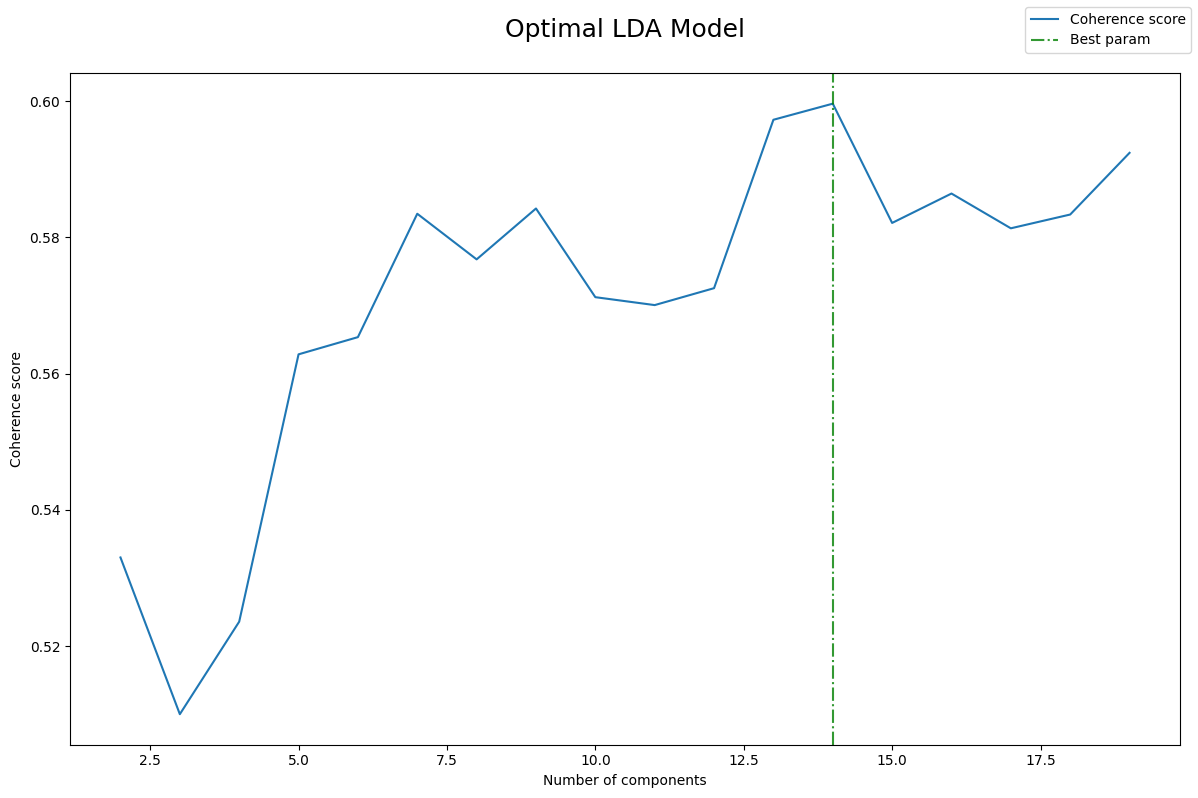

In [ ]:

# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence"])

# Select best number of topics
best_nb_topics = coherence_test\
.loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y = coherence_test["coherence"]

ax.plot(x, y, label="Coherence score")
ax.axvline(x=best_nb_topics, color='g', alpha=.8,
           linestyle='dashdot', label='Best param')
ax.set_xlabel("Number of components")
ax.set_ylabel("Coherence score")
# Title
plt.title("Optimal LDA Model\n", fontsize=18)
legend = fig.legend()

fig.tight_layout()
plt.show()

In [ ]:
# Best LDA visualization
# Construire le modèle LDA
best_lda_model = LdaMulticore(corpus=common_corpus,
                              id2word=common_dictionary,
                              num_topics=best_nb_topics,
                              per_word_topics=True,
                              passes=10,
                              workers=7)

In [ ]:
joblib.dump(common_corpus, open("gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/common_corpus.joblib", 'wb'), compress=True)
joblib.dump(common_dictionary, open("gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/common_dictionary.joblib", 'wb'), compress=True)
joblib.dump(best_lda_model, open("gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/LDA_model.joblib", 'wb'), compress=True)

Visualisation des résultats de LDA Gensim

In [ ]:
#!pip install pyLDAvis==2.1.2

In [ ]:
import pyLDAvis
import pyLDAvis.gensim as gensimvis

In [ ]:
pyLDAvis.enable_notebook()
%matplotlib inline


#gensimvis.prepare(best_lda_model, tfidf_corpus, common_dictionary)

pyLDAvis.gensim.prepare(best_lda_model, tfidf_corpus, common_dictionary)


#gensimvis.prepare(best_lda_model, corpus, id2word)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.154158 -0.171772       1        1  12.700136
13    -0.096430 -0.083972       2        1   9.436817
6     -0.167749 -0.074329       3        1   9.217265
5      0.047665  0.094679       4        1   8.716012
1      0.149597 -0.016461       5        1   7.730083
3     -0.039843 -0.107651       6        1   7.300088
9      0.064208 -0.114828       7        1   7.077957
2     -0.218646  0.016019       8        1   5.816371
11     0.119523  0.309839       9        1   5.739136
12    -0.176184  0.051122      10        1   5.586279
7     -0.112232  0.047755      11        1   5.551722
10     0.216631 -0.043987      12        1   5.340163
4     -0.007661  0.119993      13        1   5.331372
8      0.066966 -0.026406      14        1   4.456598, topic_info=         Term         Freq        Total Category  logprob  loglift
8      string  2130.000000  2130.000000  Default  30.0000  30.0000
4        java  1452.000000  1452.000000  Default  29.0000  29.0000
77       file  2505.000000  2505.000000  Default  28.0000  28.0000
218   android  1378.000000  1378.000000  Default  27.0000  27.0000
176      test  1328.000000  1328.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
129      path    37.545851   525.478162  Topic14  -5.0567   0.4720
144   problem    48.778160   977.339408  Topic14  -4.7950   0.1132
1      change    37.479765   671.835902  Topic14  -5.0585   0.2246
55   solution    32.767696   625.970308  Topic14  -5.1929   0.1609
111       app    33.094101  1196.501099  Topic14  -5.1829  -0.4770

[589 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
89        1  0.093257  access
89        2  0.157819  access
89        3  0.074127  access
89        4  0.117169  access
89        5  0.112386  access
...     ...       ...     ...
205       9  0.188704     xml
205      10  0.008205     xml
205      11  0.057432     xml
205      12  0.404756     xml
205      13  0.013674     xml

[2877 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 14, 7, 6, 2, 4, 10, 3, 12, 13, 8, 11, 5, 9])

Afin d'assigner des tags à chaque question dans ces modèles non supervisés, nous allons construire une matrice Topic/Tags en effectuant une multiplication matricielle des matrices Document/Topic et Document/Tags.


In [53]:
best_lda_model=joblib.load("gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/LDA_model.joblib")
common_corpus=joblib.load("gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/common_corpus.joblib")
common_dictionary=joblib.load("gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/common_dictionary.joblib")

In [54]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(best_lda_model\
                             .get_document_topics(common_corpus,
                                                  minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y.shape)
print('document/topic : ', doc_topic.shape)

document/tag :  (45546, 61)
document/topic :  (45546, 14)


In [55]:
# Print documents / topic matrix
doc_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.002646,0.002646,0.055449,0.002646,0.002646,0.002646,0.421726,0.097379,0.002646,0.002646,0.045213,0.002646,0.002646,0.356422
1,0.001520,0.053700,0.001520,0.001520,0.001520,0.520012,0.001520,0.001520,0.001520,0.061733,0.001520,0.001520,0.349356,0.001520
2,0.091162,0.003106,0.003106,0.071665,0.003106,0.003106,0.214096,0.003106,0.003106,0.003106,0.003106,0.403144,0.003106,0.191983


A présent, créons la matrice Topic / Tags grâce aux probabilités obtenues :

In [56]:
# Matricial multiplication with Document / Topics transpose
topic_tag = np.matmul(doc_topic.T, y)
topic_tag.shape

(14, 61)

In [57]:
topic_tag

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,609.207822,15.692950,27.774035,406.527746,16.944309,296.598967,110.584325,101.329502,259.532435,871.465066,...,25.029725,81.497479,10.157909,67.100714,393.599087,431.980219,66.181794,62.295744,272.608788,29.304900
1,87.935768,49.580555,48.481533,277.675657,23.348491,87.966394,29.708905,18.116117,44.709416,177.528425,...,26.863840,77.888451,4.148463,19.527615,17.579899,47.546294,16.160587,21.345340,152.602976,16.473686
2,286.227707,14.558246,148.696680,99.643324,458.824281,46.784811,37.941005,23.108364,108.888022,611.924018,...,104.981348,52.236489,27.398701,33.915302,19.797866,19.026925,23.186243,27.651946,30.859494,23.444843
3,131.347459,12.732190,39.838772,46.568910,31.994519,49.860792,32.946872,26.366451,27.369136,239.835240,...,56.219780,22.119522,218.287991,20.628037,12.982155,34.733028,15.488557,17.575862,13.150769,14.385079
4,120.888152,41.134282,31.714942,70.906310,47.941161,60.437811,35.211520,11.858572,29.145789,239.614792,...,36.982225,50.192117,7.848064,16.333065,15.084082,18.468293,22.014371,23.831012,26.363223,27.038911
5,142.807246,224.541203,13.934865,85.437194,36.102854,275.744780,143.814199,18.863658,26.039303,343.689722,...,36.347648,28.042912,5.920221,23.367546,23.800967,18.468404,16.877693,15.247155,16.421810,41.780790
6,260.075889,13.006905,278.283824,91.361207,205.440173,28.043427,11.322613,31.957596,943.848604,510.369714,...,145.243397,31.397836,32.060529,25.538876,40.109273,99.822960,20.696142,15.588024,29.994253,14.019851
7,299.017135,10.230677,100.809465,137.314741,88.609954,79.399321,27.525807,81.737450,98.148200,597.029948,...,573.336237,65.394255,19.333927,12.523739,26.154032,44.731398,42.197578,42.941979,32.531242,47.346155
8,199.495907,20.955716,20.329301,156.427294,17.053146,56.642161,24.177205,20.576283,56.551969,347.411442,...,29.209794,35.657730,6.358090,199.847435,38.759705,93.379820,71.415334,72.813636,58.947529,9.032829
9,228.068337,28.733360,27.436712,115.775480,29.313112,106.229789,41.135238,250.431812,73.573905,395.917369,...,43.104243,20.054188,42.707529,26.504958,40.841269,168.727380,50.743533,27.586792,43.402213,41.982606


Donc, nous générons une matrice où les lignes représentent les Topics créés et les colonnes représentent les Tags associés et leurs distributions. Ainsi, pour chaque document, nous allons créer nos prédictions en utilisant les n premiers tags associés aux topics

In [58]:
y_results = pd.DataFrame(tags)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results["frequent_tags"].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results.head(3)

,frequent_tags,best_topic,nb_tags,y_true
0,"[java, multithreading]",6,2,"[24, 33]"
1,"[php, html]",5,2,"[20, 40]"
2,"[ios, objective-c, xcode]",11,3,"[22, 36, 59]"


In [59]:
# Select predicted tags in Topics / Tags matrix
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)

y_results["y_pred"] = list_tag
y_results.head(3)

,frequent_tags,best_topic,nb_tags,y_true,y_pred
0,"[java, multithreading]",6,2,"[24, 33]","[10, 8]"
1,"[php, html]",5,2,"[20, 40]","[25, 26]"
2,"[ios, objective-c, xcode]",11,3,"[22, 36, 59]","[3, 22, 12]"


Nous allons évaluer plusieurs métriques sur ce modèle LDA :

- Taux de précision (Accuracy score)
- Score F1 (F1 score)
- Coefficient de similarité de Jaccard (Jaccard similarity score)
- Rappel (Recall)
- Précision (Precision)

In [4]:
def metrics_score(model, df, y_true, y_pred):
    """Compilation function of metrics specific to multi-label
    classification problems in a Pandas DataFrame.
    This dataFrame will have 1 row per metric
    and 1 column per model tested.

    Parameters
    ----------------------------------------
    model : string
        Name of the tested model
    df : DataFrame
        DataFrame to extend.
        If None : Create DataFrame.
    y_true : array
        Array of true values to test
    y_pred : array
        Array of predicted values to test
    ----------------------------------------
    """
    if(df is not None):
        temp_df = df
    else:
        temp_df = pd.DataFrame(index=["Accuracy", "F1",
                                      "Jaccard", "Recall",
                                      "Precision"],
                               columns=[model])

    scores = []
    scores.append(metrics.accuracy_score(y_true,
                                         y_pred))
    scores.append(metrics.f1_score(y_pred,
                                   y_true,
                                   average='weighted'))
    scores.append(metrics.jaccard_score(y_true,
                                        y_pred,
                                        average='weighted'))
    scores.append(metrics.recall_score(y_true,
                                       y_pred,
                                       average='weighted'))
    scores.append(metrics.precision_score(y_true,
                                          y_pred,
                                          average='weighted'))
    temp_df[model] = scores

    return temp_df

In [60]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(y.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1

lda_y_true = np.zeros(y.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [75]:
df_metrics_compare = metrics_score("LDA", df=None,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

,LDA
Accuracy,0.115510
F1,0.329347
Jaccard,0.124074
Recall,0.267508
Precision,0.206848


In [80]:
joblib.dump(df_metrics_compare, open("gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/df_metrics_compare_lda.joblib", 'wb'), compress=True)

## Modèle NMF

Nous allons donc nous baser sur les résultats de la LDA pour déterminer un nombre correct de composants. Ici, nous prendrons 12 topics pour avoir un bon compromis "temps d'entrainement" / précision et utiliserons les matrices Tfidf créées lors du preprocessing.

In [ ]:
def plot_top_words(model, feature_names,
                   n_top_words, nb_topic_plot, title):
    """Function for displaying the plots of the
    best x words representative of the categories of NMF.

    Parameters
    ----------------------------------------
    model : NMF model
        Fitted model of NMF to plot
    feature_names : array
        Categories result of the vectorizer (TFIDF ...)
    n_top_words : int
        Number of words for each topic.
    title : string
        Title of the plot.
    ----------------------------------------
    """
    rows = int(nb_topic_plot/6)
    fig, axes = plt.subplots(rows, 6,
                             figsize=(30, rows*10),
                             sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        if(topic_idx < nb_topic_plot):
            top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
            top_features = [feature_names[i] for i in top_features_ind]
            weights = topic[top_features_ind]

            ax = axes[topic_idx]
            bartopic = ax.barh(top_features, weights, height=0.7)
            bartopic[0].set_color('#f48023')
            ax.set_title(f'Topic {topic_idx +1}',
                         fontdict={'fontsize': 30})
            ax.invert_yaxis()
            ax.tick_params(axis='both', which='major', labelsize=20)
            for i in 'top right left'.split():
                ax.spines[i].set_visible(False)
            fig.suptitle(title, fontsize=36, color="#641E16")

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [ ]:
# Define number of topics to test
n_topics = 13

print("-"*50)
print("Start NMF fitting on Full_doc ...")
print("-" * 50)
start_time = time.time()
# Initializing the NMF
full_nmf = NMF(n_components=n_topics,
               init='nndsvd',
               random_state=8)

# Fit NMF on Body vectorized
full_nmf.fit(X_tfidf_train)

exec_time = time.time() - start_time
print("End of training :")
print("Execution time : {:.2f}s".format(exec_time))
print("-" * 50)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--------------------------------------------------
Start NMF fitting on Full_doc ...
--------------------------------------------------
End of training :
Execution time : 37.86s
--------------------------------------------------


In [ ]:
# Plot the 6 first topics
ff_feature_names = tfidf.get_feature_names_out()
plot_top_words(full_nmf, ff_feature_names, 20, 6,
               'Topics in NMF model for Full_doc')

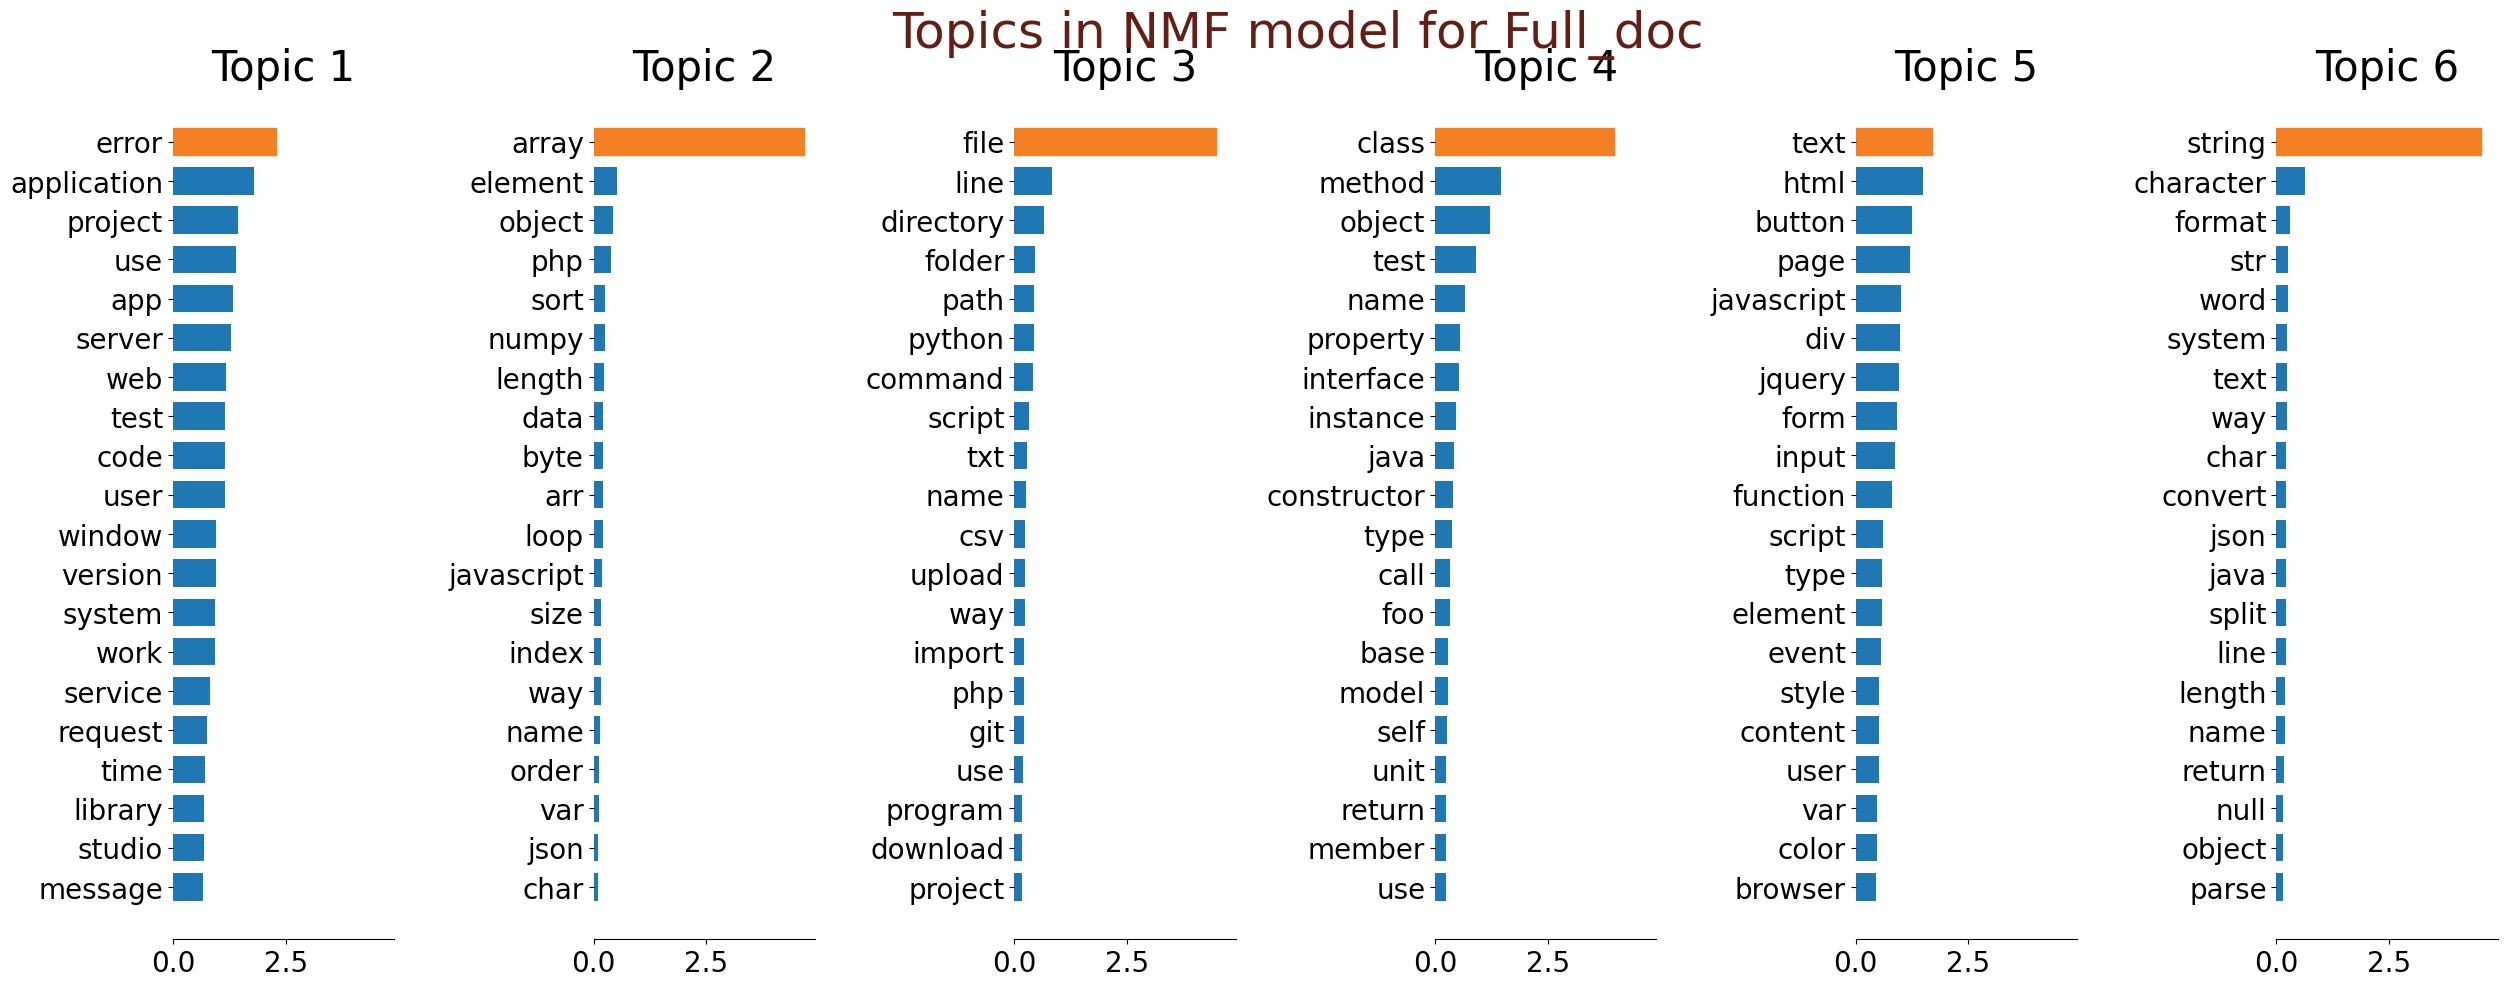

# Modèles supervisés

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, jaccard_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics

In [58]:
#TDIDF
X_train_tfidf = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_tfidf_train.joblib')
X_test_tfidf = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_tfidf_test.joblib')


#Word2Vec
Xw2v_train = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_w2v_train.joblib')
Xw2v_test = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_w2v_test.joblib')


#Bert
X_train_bert = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_bert_test.joblib')
X_test_bert = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_bert_train.joblib')


#Use
X_use_train = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_use_train.joblib')
X_use_train= joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_use_test.joblib')

#Données réelles et target
X_train = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_train.joblib')
X_test = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/X_test.joblib')

y_train = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_train.joblib')
y_test = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_test.joblib')

y_train_bert =joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_train_bert.joblib')
y_test_bert =joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_test_bert.joblib')

y_use_train =joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_use_train.joblib')
y_use_test =joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/y_use_test.joblib')

In [65]:
multilabel = joblib.load('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Variables/multilabel.joblib')

In [66]:
X_train_tfidf.head(2)

,abc,access,accord,account,action,activerecord,activity,activitythread,adapter,address,...,write,writeline,www,xcode,xml,xmlns,xxx,year,zip,zygoteinit
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## <ins>TFIDF </ins>

### Logistic Regression (tdidf)

In [67]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
%%time
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

multi_logit_cv = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_cv.fit(X_train_tfidf, y_train)

Wall time: 4min 18s


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [ ]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_cv.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_cv.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 10, 'estimator__dual': False, 'estimator__penalty': 'l1', 'estimator__solver': 'liblinear'}


In [71]:
%%time
# Predict
y_test_predicted_labels_tfidf = multi_logit_cv.predict(X_test_tfidf)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('node.js',), ('c#',), ('php',), ('ios', 'objective-c'), ('asp.net',), (), ('android',), ('java',), ('mysql', 'ruby')]
True: [('java',), ('javascript', 'node.js'), ('java',), ('bash', 'php'), ('cocoa-touch', 'iphone', 'objective-c'), ('.net', 'asp.net', 'c#'), ('php',), ('android',), ('java',), ('mysql', 'ruby')]
CPU times: user 1.81 s, sys: 900 ms, total: 2.71 s
Wall time: 1.9 s


In [76]:
df_metrics_compare = metrics_score("Logit(Tdidf)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf)
df_metrics_compare

,LDA,Logit(Tdidf)
Accuracy,0.115510,0.270220
F1,0.329347,0.605627
Jaccard,0.124074,0.424862
Recall,0.267508,0.497897
Precision,0.206848,0.699512


In [77]:
joblib.dump(multi_logit_cv , open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/logit_tdidf.joblib', 'wb'), compress=True)

## Random forest (tdidf)

In [ ]:
%%time
# Initialize RandomForest with OneVsRest
param_rfc = {"estimator__max_depth": [5, 25, 50],
             "estimator__min_samples_leaf": [1, 5, 10],
             "estimator__class_weight": ["balanced"]}

multi_rfc_cv = GridSearchCV(OneVsRestClassifier(RandomForestClassifier()),
                            param_grid=param_rfc,
                            n_jobs=-1,
                            cv=2,
                            scoring="f1_weighted",
                            return_train_score = True,
                            refit=True,
                            verbose=3)
# Fit on Sample data
multi_rfc_cv.fit(X_train_tfidf[0:7000], y_train[0:7000])

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Wall time: 5min 14s


GridSearchCV(cv=2,
             estimator=OneVsRestClassifier(estimator=RandomForestClassifier()),
             n_jobs=-1,
             param_grid={'estimator__class_weight': ['balanced'],
                         'estimator__max_depth': [5, 25, 50],
                         'estimator__min_samples_leaf': [1, 5, 10]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [ ]:
rfc_cv_results = pd.DataFrame.from_dict(multi_rfc_cv.cv_results_)
print("-"*50)
print("Best params for RandomForestClassifier")
print("-" * 50)
rfc_best_params = multi_rfc_cv.best_params_
print(rfc_best_params)

--------------------------------------------------
Best params for RandomForestClassifier
--------------------------------------------------
{'estimator__class_weight': 'balanced', 'estimator__max_depth': 25, 'estimator__min_samples_leaf': 5}


In [ ]:
rfc_best_params_ok = {}
for k, v in rfc_best_params.items():
    rfc_best_params_ok[k.replace("estimator__","")] = v

In [78]:
%%time
# Refit RandomForestClassifier best_params with full dataset
rfc_final_model = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
rfc_final_model.fit(X_train_tfidf, y_train)

# Predict
y_test_predicted_labels_tfidf_rfc = rfc_final_model.predict(X_test_tfidf)

# Inverse transform
y_test_pred_inversed_rfc = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_rfc)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_rfc[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('c#',), ('c#', 'javascript', 'node.js'), ('.net',), ('git', 'php'), ('cocoa-touch', 'ios', 'iphone', 'objective-c', 'swift')]
True: [('java',), ('javascript', 'node.js'), ('java',), ('bash', 'php'), ('cocoa-touch', 'iphone', 'objective-c')]


In [79]:
df_metrics_compare = metrics_score("RandomForest (Tdidf)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_rfc)
df_metrics_compare

,LDA,Logit(Tdidf),RandomForest (Tdidf)
Accuracy,0.115510,0.270220,0.195047
F1,0.329347,0.605627,0.592419
Jaccard,0.124074,0.424862,0.465299
Recall,0.267508,0.497897,0.736675
Precision,0.206848,0.699512,0.552882


In [81]:
joblib.dump(rfc_final_model , open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/RF_final_model_tdidf.joblib', 'wb'), compress=True)

## RandomForest avec Classifier Chains (tdidf)

In [83]:
from sklearn.multioutput import ClassifierChain

In [84]:
%%time
rfc_base_model = RandomForestClassifier(**rfc_best_params_ok)
chain = ClassifierChain(rfc_base_model, order='random')
chain.fit(X_train_tfidf, y_train)

CPU times: user 14.5 s, sys: 7.59 s, total: 22 s
Wall time: 16min 52s


ClassifierChain(base_estimator=OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                                                    max_depth=25,
                                                                                    min_samples_leaf=5,
                                                                                    n_jobs=-1),
                                                   n_jobs=-1),
                order='random')

In [85]:
# Predict
y_test_predicted_labels_tfidf_chain = chain.predict(X_test_tfidf)

# Inverse transform
y_test_pred_inversed_chain = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_tfidf_chain)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed_chain[0:5])
print("True:", y_test_inversed[0:5])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('java',), ('javascript', 'node.js'), ('.net', 'c#', 'winforms'), ('bash', 'php'), ('cocoa-touch', 'ios', 'iphone', 'objective-c', 'swift', 'xcode')]
True: [('java',), ('javascript', 'node.js'), ('java',), ('bash', 'php'), ('cocoa-touch', 'iphone', 'objective-c')]


In [86]:
Tags_per_row_chain = y_test_predicted_labels_tfidf_chain.sum(axis=1)
null_rate_chain = round(((Tags_per_row_chain.size - np.count_nonzero(Tags_per_row_chain))
                       /Tags_per_row_chain.size)*100,2)
print("-"*50)
print("Percentage of non tagged question for chain model")
print("-" * 50)
print("RandomForest with Classifier Chains: {}%".format(null_rate_chain))

--------------------------------------------------
Percentage of non tagged question for chain model
--------------------------------------------------
RandomForest with Classifier Chains: 1.94%


In [87]:
df_metrics_compare = metrics_score("RFC Chains (Tdidf)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_tfidf_chain)
df_metrics_compare

,LDA,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf)
Accuracy,0.115510,0.270220,0.195047,0.177659
F1,0.329347,0.605627,0.592419,0.547754
Jaccard,0.124074,0.424862,0.465299,0.441744
Recall,0.267508,0.497897,0.736675,0.733839
Precision,0.206848,0.699512,0.552882,0.531306


In [90]:
joblib.dump(chain , open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/RF_chain_classifier_tdidf.joblib', 'wb'), compress=True)

# <ins> Word2vec </in>

## logistic regression (w2vec)

In [ ]:
%%time
# Initialize Logistic Regression with OneVsRest
param_logit = {"estimator__C": [100, 10, 1.0, 0.1],
               "estimator__penalty": ["l1", "l2"],
               "estimator__dual": [False],
               "estimator__solver": ["liblinear"]}

multi_logit_w2v = GridSearchCV(OneVsRestClassifier(LogisticRegression()),
                              param_grid=param_logit,
                              n_jobs=-1,
                              cv=5,
                              scoring="f1_weighted",
                              return_train_score = True,
                              refit=True)
multi_logit_w2v.fit(Xw2v_train, y_train)

Wall time: 27min


GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 1.0, 0.1],
                         'estimator__dual': [False],
                         'estimator__penalty': ['l1', 'l2'],
                         'estimator__solver': ['liblinear']},
             return_train_score=True, scoring='f1_weighted')

In [ ]:
logit_cv_results = pd.DataFrame.from_dict(multi_logit_w2v.cv_results_)
print("-"*50)
print("Best params for Logistic Regression")
print("-" * 50)
logit_best_params = multi_logit_w2v.best_params_
print(logit_best_params)

--------------------------------------------------
Best params for Logistic Regression
--------------------------------------------------
{'estimator__C': 100, 'estimator__dual': False, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}


In [31]:
%%time
# Predict
y_test_predicted_labels_w2v = multi_logit_w2v.predict(Xw2v_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_w2v)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), ('node.js',), (), ('php',), ('ios', 'objective-c'), (), (), ('android',), (), ('mysql',)]
True: [('java',), ('javascript', 'node.js'), ('java',), ('bash', 'php'), ('cocoa-touch', 'iphone', 'objective-c'), ('.net', 'asp.net', 'c#'), ('php',), ('android',), ('java',), ('mysql', 'ruby')]
CPU times: user 415 ms, sys: 243 ms, total: 659 ms
Wall time: 380 ms


In [32]:
df_metrics_compare = metrics_score("Logit (w2vec)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_w2v)
df_metrics_compare

,LDA,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec)
Accuracy,0.115510,0.270220,0.195047,0.177659,0.196013
F1,0.329347,0.605627,0.592419,0.547754,0.502265
Jaccard,0.124074,0.424862,0.465299,0.441744,0.312506
Recall,0.267508,0.497897,0.736675,0.733839,0.359804
Precision,0.206848,0.699512,0.552882,0.531306,0.659106


In [34]:
joblib.dump(multi_logit_w2v , open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/logit_w2v.joblib', 'wb'), compress=True)

## Random Forest (w2vec)

In [ ]:
%%time
RF_model_w2v = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
RF_model_w2v.fit(Xw2v_train,y_train)

# Predict
y_test_predicted_labels_w2v_rfc = RF_model_w2v.predict(Xw2v_test)

In [38]:
df_metrics_compare = metrics_score("RandomForest (w2vec)",
                                   df=df_metrics_compare,
                                   y_true = y_test,
                                   y_pred = y_test_predicted_labels_w2v_rfc)
df_metrics_compare

,LDA,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec),RandomForest (w2vec)
Accuracy,0.115510,0.270220,0.195047,0.177659,0.196013,0.148327
F1,0.329347,0.605627,0.592419,0.547754,0.502265,0.458119
Jaccard,0.124074,0.424862,0.465299,0.441744,0.312506,0.295880
Recall,0.267508,0.497897,0.736675,0.733839,0.359804,0.368557
Precision,0.206848,0.699512,0.552882,0.531306,0.659106,0.612512


In [39]:
joblib.dump(RF_model_w2v, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/RF_model_w2v.joblib', 'wb'), compress=True)

# <ins> BERT </ins>

## Logistic regression (bert)

In [73]:
%%time
multi_logit_bert = OneVsRestClassifier(LogisticRegression(C=10, penalty="l1", dual=False, solver="liblinear",n_jobs=-1),n_jobs=-1)
multi_logit_bert.fit(X_train_bert, y_train_bert)

'%%time\nmulti_logit_bert = OneVsRestClassifier(LogisticRegression(C=10, penalty="l1", dual=False, solver="liblinear",n_jobs=-1),n_jobs=-1)\nmulti_logit_bert.fit(X_train_bert, y_train_bert)'

In [78]:
%%time
# Predict
y_test_predicted_labels_bert = multi_logit_bert.predict(X_test_bert)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_bert)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_test_bert)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [(), (), (), ('php',), ('ios', 'objective-c'), ('debugging',), ('php', 'visual-studio'), ('android', 'winforms'), (), ('ruby', 'ruby-on-rails')]
True: [('java',), ('javascript', 'node.js'), ('java',), ('bash', 'php'), ('cocoa-touch', 'iphone', 'objective-c'), ('.net', 'asp.net', 'c#'), ('php',), ('android',), ('java',), ('mysql', 'ruby')]
CPU times: user 1.39 s, sys: 2.15 s, total: 3.54 s
Wall time: 2.79 s


In [79]:
df_metrics_compare = metrics_score("Logit(BERT)",
                                   df=df_metrics_compare,
                                   y_true = y_test_bert,
                                   y_pred = y_test_predicted_labels_bert)
df_metrics_compare

,LDA,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec),RandomForest (w2vec),Logit(BERT)
Accuracy,0.115510,0.270220,0.195047,0.177659,0.196013,0.148327,0.235093
F1,0.329347,0.605627,0.592419,0.547754,0.502265,0.458119,0.553240
Jaccard,0.124074,0.424862,0.465299,0.441744,0.312506,0.295880,0.374888
Recall,0.267508,0.497897,0.736675,0.733839,0.359804,0.368557,0.450318
Precision,0.206848,0.699512,0.552882,0.531306,0.659106,0.612512,0.664646


## Random Forest (bert)

In [50]:
%%time
RF_model_bert = OneVsRestClassifier(RandomForestClassifier(class_weight='balanced', max_depth=25,min_samples_leaf=5))
RF_model_bert.fit(X_train_bert,y_train_bert)

# Predict
y_test_predicted_labels_bert_rfc = RF_model_bert.predict(X_test_bert)

CPU times: user 1h 24min 9s, sys: 3.23 s, total: 1h 24min 13s
Wall time: 1h 24min 25s


In [83]:
df_metrics_compare = metrics_score("RandomForest (Bert)",
                                   df=df_metrics_compare,
                                   y_true = y_test_bert,
                                   y_pred = y_test_predicted_labels_bert_rfc)
df_metrics_compare

,LDA,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec),RandomForest (w2vec),Logit(BERT),RandomForest (Bert)
Accuracy,0.115510,0.270220,0.195047,0.177659,0.196013,0.148327,0.235093,0.235093
F1,0.329347,0.605627,0.592419,0.547754,0.502265,0.458119,0.553240,0.553240
Jaccard,0.124074,0.424862,0.465299,0.441744,0.312506,0.295880,0.374888,0.374888
Recall,0.267508,0.497897,0.736675,0.733839,0.359804,0.368557,0.450318,0.450318
Precision,0.206848,0.699512,0.552882,0.531306,0.659106,0.612512,0.664646,0.664646


# <ins> USE </ins>

## Logistic regression (use)

In [100]:
%%time
# Initialize Logistic Regression with OneVsRest
multi_logit_use =OneVsRestClassifier(LogisticRegression(C=10, penalty="l1", dual=False, solver="liblinear",n_jobs=-1),n_jobs=-1)
multi_logit_use.fit(X_use_train, y_use_train)

CPU times: user 28.5 s, sys: 6.81 s, total: 35.3 s
Wall time: 58min 39s


OneVsRestClassifier(estimator=LogisticRegression(C=10, n_jobs=-1, penalty='l1',
                                                 solver='liblinear'),
                    n_jobs=-1)

In [101]:
%%time
# Predict
y_test_predicted_labels_use= multi_logit_use.predict(X_use_test)

# Inverse transform
y_test_pred_inversed = multilabel_binarizer\
    .inverse_transform(y_test_predicted_labels_use)
y_test_inversed = multilabel_binarizer\
    .inverse_transform(y_use_test)

print("-"*50)
print("Print 5 first predicted Tags vs true Tags")
print("-" * 50)
print("Predicted:", y_test_pred_inversed[0:10])
print("True:", y_test_inversed[0:10])

--------------------------------------------------
Print 5 first predicted Tags vs true Tags
--------------------------------------------------
Predicted: [('datetime',), ('node.js',), (), ('bash', 'php'), ('ios', 'iphone', 'objective-c'), ('asp.net', 'c#'), ('php',), ('android',), ('java',), ('macos', 'mysql', 'ruby', 'ruby-on-rails')]
True: [('java',), ('javascript', 'node.js'), ('java',), ('bash', 'php'), ('cocoa-touch', 'iphone', 'objective-c'), ('.net', 'asp.net', 'c#'), ('php',), ('android',), ('java',), ('mysql', 'ruby')]
CPU times: user 1.02 s, sys: 1.3 s, total: 2.31 s
Wall time: 1.22 s


In [102]:
df_metrics_compare = metrics_score("Logit (Use)",
                                   df=df_metrics_compare,
                                   y_true = y_use_test,
                                   y_pred = y_test_predicted_labels_use)
df_metrics_compare

,LDA,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec),RandomForest (w2vec),Logit(BERT),RandomForest (Bert),Logit (Use)
Accuracy,0.115510,0.270220,0.195047,0.177659,0.196013,0.148327,0.235093,0.235093,0.269957
F1,0.329347,0.605627,0.592419,0.547754,0.502265,0.458119,0.553240,0.553240,0.609297
Jaccard,0.124074,0.424862,0.465299,0.441744,0.312506,0.295880,0.374888,0.374888,0.432627
Recall,0.267508,0.497897,0.736675,0.733839,0.359804,0.368557,0.450318,0.450318,0.528166
Precision,0.206848,0.699512,0.552882,0.531306,0.659106,0.612512,0.664646,0.664646,0.666583


In [104]:
joblib.dump(multi_logit_use, open('gdrive/My Drive/Colab Notebooks/Ingenieur IA/Mission_4 Catégorisez automatiquement des questions/Model/logit_use.joblib', 'wb'), compress=True)

## Random Forest (use)

In [ ]:
%%time
RF_model_use = OneVsRestClassifier(RandomForestClassifier(**rfc_best_params_ok))
RF_model_use.fit(X_use_train ,y_use_train)

# Predict
y_test_predicted_labels_use_rfc = RF_model_use.predict(X_use_test)

In [107]:
df_metrics_compare = metrics_score("RandomForest (Use)",
                                   df=df_metrics_compare,
                                   y_true = y_use_test,
                                   y_pred = y_test_predicted_labels_use_rfc)
df_metrics_compare

,LDA,Logit(Tdidf),RandomForest (Tdidf),RFC Chains (Tdidf),Logit (w2vec),RandomForest (w2vec),Logit(BERT),RandomForest (Bert),Logit (Use),RandomForest (Use)
Accuracy,0.115510,0.270220,0.195047,0.177659,0.196013,0.148327,0.235093,0.235093,0.269957,0.243962
F1,0.329347,0.605627,0.592419,0.547754,0.502265,0.458119,0.553240,0.553240,0.609297,0.592319
Jaccard,0.124074,0.424862,0.465299,0.441744,0.312506,0.295880,0.374888,0.374888,0.432627,0.423200
Recall,0.267508,0.497897,0.736675,0.733839,0.359804,0.368557,0.450318,0.450318,0.528166,0.518680
Precision,0.206848,0.699512,0.552882,0.531306,0.659106,0.612512,0.664646,0.664646,0.666583,0.674297


## Benchmark modèles

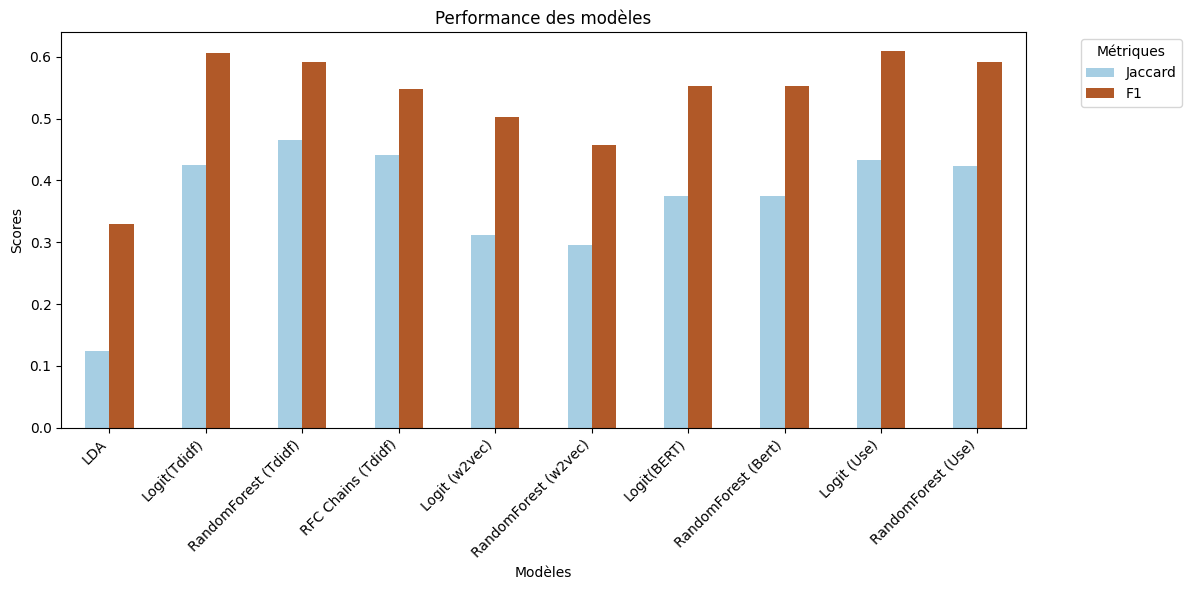

In [128]:
#df.set_index('Model', inplace=True)
#df.sort_values(by='F1', inplace=True)
# Création du graphique à barres
ax = df_metrics_compare.loc[['Jaccard','F1']].T.plot(kind='bar', figsize=(12, 6), colormap='Paired')

# Personnalisation du graphique
plt.title('Performance des modèles')
plt.xlabel('Modèles')
plt.ylabel('Scores')
plt.legend(title='Métriques', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

# Affichage du graphique
plt.tight_layout()
plt.show()